## Imports

In [1]:
import torch
import torchvision
import ultralytics

from pathlib import Path

from PIL import Image
import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np

## Setup

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# load models saved to system

# replace the paths here with the paths to your models

# pytorch
path_to_faster = "path/to/faster.pth"
path_to_ssd = "path/to/ssd.pth"
path_to_retina_net = "path/to/retina_net.pth"
# ultralytics
path_to_yolo = "path/to/best_yolo.pt"

dictionary_of_models = {0: path_to_yolo, 1: path_to_faster, 2: path_to_ssd, 3: path_to_retina_net}

### Initializing models

In [4]:
from functools import partial
def get_model(num_classes, model_ind=1, weights="DEFAULT"):
  """
  model_inds:
  1: fasterrcnn_resnet50_fpn
  2: ssd320lite_mobilenetv3
  3: retinanet_resnet50_fpn
  """

  if model_ind == 1:
    # load a pre-trained model for classification
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # the roi heads are the heads for the region of interest.
    # it includes the box predictor.
    # the box predictor includes the classification score, which is the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

  if model_ind == 2:
      model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights="DEFAULT", pretrained=True)
      in_channels = torchvision.models.detection._utils.retrieve_out_channels(model.backbone, (320, 320))
      num_anchors = model.anchor_generator.num_anchors_per_location()
      print("number of anchors:", num_anchors)
      norm_layer  = partial(torch.nn.BatchNorm2d, eps=0.001, momentum=0.03)

      model.head.classification_head = torchvision.models.detection.ssdlite.SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer)

  if model_ind == 3:
        model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
        weights="DEFAULT", pretrained=True
    )
        num_anchors = model.head.classification_head.num_anchors
        model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
          in_channels=256, # in line with
          num_anchors=num_anchors,
          num_classes=num_classes,
          norm_layer=partial(torch.nn.GroupNorm, 32)
    )

  return model

### pytorch model prediction

In [5]:

def pytorch_prediction(model, model_path, img):
    # preprocess the image

    # original_img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = img.astype(np.float32)

    # convert to tensor
    img = torch.tensor(img, dtype=torch.float32)
    img = img.permute(2, 0, 1) # this is done to match the shape of the input tensor, which is channel, height, width
    img = img.unsqueeze(0) # this is done to match the shape of the input tensor, which is batch_size, channel, height, width

    # load the model
    weights = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(weights)
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    return prediction

### ultralytics model prediction

In [6]:

def ultralytics_prediction(model_path, img):
    model = ultralytics.YOLO(model_path)
    prediction = model(img)
    return prediction

### bounding box visualization

In [7]:
def display_img(img, prediction):
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

### pytorch prediction display

In [8]:
def pytorch_display_img(img, prediction):
    print("Number of predictions: ", len(prediction[0]["boxes"]))
    display_img(img, prediction)

### ultralytics prediction display

In [9]:
def ultralytics_display_img(img,prediction):
    boxes = prediction[0].boxes.xyxyn # returns (x1, y1, x2, y2 normalized)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = x1 * img.shape[1], y1 * img.shape[0], x2 * img.shape[1], y2 * img.shape[0]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

    prediction[0].show()

### prediction

In [10]:
def predict(model_num, path_to_img):
    model_path = dictionary_of_models[model_num]
    img = cv2.imread(path_to_img)
    num_classes = 2
    if model_num == 0:
        prediction = ultralytics_prediction(model_path, img)
        ultralytics_display_img(img,prediction)
    else:
        model = get_model(num_classes, model_num)
        prediction = pytorch_prediction(model, model_path, img)
        pytorch_display_img(img, prediction)

### choose the model and provide the image path

model indices:

* 0: YOLO
* 1: Faster R-CNN
* 2: SSD MobileNet
* 3: RetinaNet

In [11]:
model_num = 1
path_to_img = "/Users/ananyageorge/vit/capstone-2024/predictor_app/images_for_testing/015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg"

Number of predictions:  100


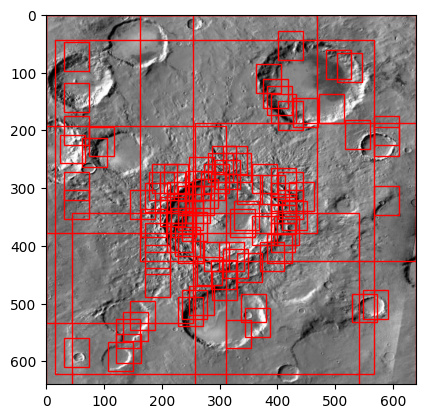

In [12]:
predict(model_num, path_to_img)

/Users/ananyageorge/vit/capstone-2024/predictor_app/models/content/runs/detect/train/weights/best.pt

0: 640x640 12 craters, 219.8ms
Speed: 4.8ms preprocess, 219.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


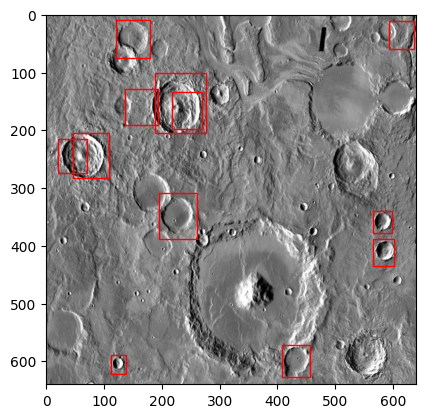

In [13]:
predict(0, "/Users/ananyageorge/vit/capstone-2024/predictor_app/images_for_testing/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg")

Number of predictions:  100


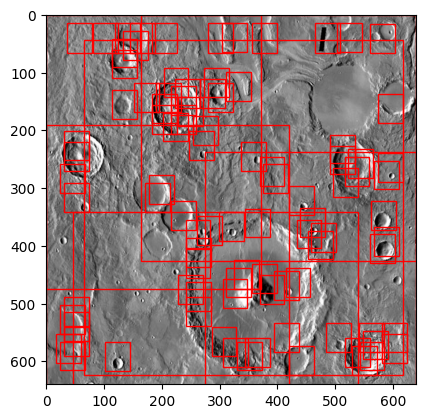

number of anchors: [6, 6, 6, 6, 6, 6]
Number of predictions:  169


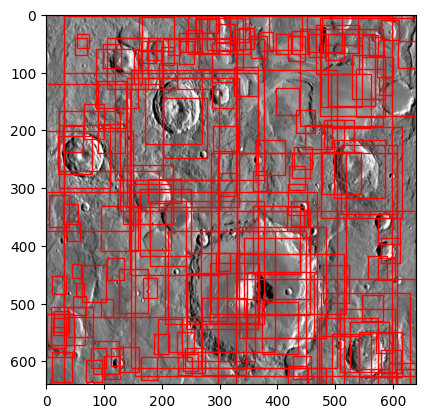

Number of predictions:  300


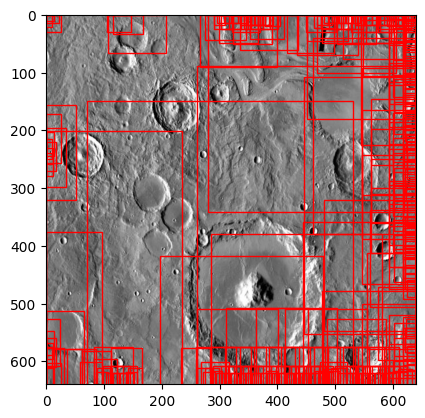

In [14]:
predict(1, "/Users/ananyageorge/vit/capstone-2024/predictor_app/images_for_testing/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg")
predict(2, "/Users/ananyageorge/vit/capstone-2024/predictor_app/images_for_testing/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg")
predict(3, "/Users/ananyageorge/vit/capstone-2024/predictor_app/images_for_testing/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg")
